In [14]:
import os 
import matplotlib
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import requests
import re
import datetime
import joblib

from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import roc_auc_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM
import torch

currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
year = int(date.strftime("%Y"))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = "#949494"

%matplotlib inline

In [15]:
od.download('https://www.kaggle.com/c/playground-series-s4e9')
os.listdir('playground-series-s4e9')
train = pd.read_csv('playground-series-s4e9/train.csv', low_memory=False)
test = pd.read_csv('playground-series-s4e9/test.csv', low_memory=False)
sub = pd.read_csv('playground-series-s4e9/sample_submission.csv')

Skipping, found downloaded files in "./playground-series-s4e9" (use force=True to force download)


In [16]:
N_THREADS = 16
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600

In [17]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [18]:
def convert_engine(val):
    d = {
        'engine_HP': np.nan,
        'engine_L': np.nan,
        'engine_cylinder': np.nan,
        'engine_cylinder_type': np.nan,
        'engine_fuel_type': np.nan,
        'engine_type': np.nan,
        'engine_v': np.nan,
        'engine_vtype': np.nan
    }
    spl = val.replace('-', '').split(' ')
    pos_v1 = -1
    pos_v2 = -1
    for i, v in enumerate(spl):
        if v.endswith('HP'):
            d['engine_HP'] = float(v[:-2])
        elif v.endswith('L'):
            d['engine_L'] = float(v[:-1])
        elif v == 'Engine' and spl[i-1] == 'Cylinder':
            d['engine_cylinder'] = abs(float(spl[i-2].replace('V', '')))
        elif v == 'Fuel':
            d['engine_fuel_type'] = spl[i - 1]
        elif v == 'Liter':
            d['engine_L'] = float(spl[i-1])
        elif v.startswith('V') or v.startswith('H') or v.startswith('I'):
            try:
                d['engine_cylinder'] = float(v[1:])
                d['engine_cylinder_type'] = v[0]
                pos_v1 = i
            except:
                pass
        elif v == 'DOHC' or v == 'OHV':
            d['engine_type'] = ' '.join(spl[i:])
            if pos_v2 != -1:
                d['engine_vtype'] = ' '.join(spl[pos_v2+1:i])
            elif pos_v1 != -1:
                d['engine_vtype'] = ' '.join(spl[pos_v1+1:i])
        elif v.endswith('V'):
            try:
                d['engine_v'] = float(v[:-1])
                pos_v2 = i
            except:
                pass
    return d

def test_params(ModelClass, **params):
    model = ModelClass(**params).fit(X_train, Y_train)
    train_rmse = rmse(model.predict(X_train), Y_train)
    val_rmse = rmse(model.predict(X_val), Y_val)
    return train_rmse, val_rmse


def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    for x,y in zip(param_values,val_errors):
        label = "{:.2f}".format(y)
        plt.annotate(label,
                    (x,y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [19]:
average_prices_by_brand = train.groupby('brand')['price'].mean()

train = train.fillna('dash')
train = train.replace('–', 'dash')

test = test.fillna('dash')
test = test.replace('–', 'dash')

accident_dict = {
    'None reported': 0,
    'At least 1 accident or damage reported': 1,
    'uknown': 2
}

clean_title_dict = {
    'Yes': 0,
    'uknown': 1
}

expensive_ext_color = ['Blue Caelum', 'Dark Sapphire', 'Bianco Monocerus', 'C / C', 'Ice',
       'Tempest', 'Beluga Black', 'Bianco Icarus Metallic', 
       'BLU ELEOS', 'Shadow Black', 'Nero Noctis', 'Sandstone Metallic',
       'Lizard Green', 'Balloon White', 'Onyx', 'Donington Grey Metallic',
       'China Blue', 'Diamond White', 'Rosso Corsa', 'Granite',
       'Rosso Mars Metallic', 'Carpathian Grey', 'Kemora Gray Metallic',
       'Grigio Nimbus', 'dash', 'Bianco Isis', 'Python Green', 'Fountain Blue',
       'Custom Color', 'Vega Blue', 'Designo Magno Matte',
       'Brands Hatch Gray Metallic', 'Rift Metallic', 'Gentian Blue Metallic',
       'Arancio Borealis', 'BLUE', 'Aventurine Green Metallic', 'Apex Blue',
       'Daytona Gray Pearl Effect', 'Daytona Gray Pearl Effect w/ Black Roof',
       'Matte White', 'Carpathian Grey Premium Metallic', 'Blue Metallic',
       'Santorini Black Metallic', 'Quartzite Grey Metallic',
       'Carrara White Metallic', 'BLACK', 'Kinetic Blue', 'Nero Daytona']

expensive_int_color = ['Dark Auburn', 'Hotspur', 'Cobalt Blue', 'Beluga Hide', 'Linen',
                       'Beluga', 'Black / Brown', 'Nero Ade', 'Sahara Tan', 'Portland']

inexpensive_ext_color = ['Gold', 'Frozen White', 'Beige', 'Volcanic Orange',
        'Mountain Air Metallic', 'Crystal Black Pearl', 'Crimson Red Tintcoat',
        'Snowflake White Pearl', 'Sonic Silver Metallic', 'Radiant Red Metallic II',
        'Remington Red Metallic', 'Gecko Pearlcoat', 'Dazzling White',
        'Blue Reflex Mica', 'White Platinum Tri-Coat Metallic', 'Purple',
        'Crystal White Pearl', 'Silver', 'Jet Black Mica', 'Red Quartz Tintcoat']

inexpensive_int_color =['Light Gray', 'Gray', 'Medium Pewter', 'Beige', 'Medium Ash Gray',
       'White / Brown', 'Ash', 'Deep Chestnut', 'Charcoal Black',
       'Whisper Beige', 'Gideon', 'Light Platinum / Jet Black', 'Sand Beige',
       'Mountain Brown', 'Ivory / Ebony', 'Black / Graphite', 'Canberra Beige',
       'Tupelo', 'Charcoal', 'Gold']

low_end_brand = average_prices_by_brand[average_prices_by_brand < 25000].index.tolist()
mid_range_brand = average_prices_by_brand[(average_prices_by_brand > 25000) & (average_prices_by_brand < 40000)].index.tolist()
high_end_brand = average_prices_by_brand[(average_prices_by_brand > 40000) & (average_prices_by_brand < 80000)].index.tolist()
luxury_brand = average_prices_by_brand[average_prices_by_brand > 80000].index.tolist()

def encode_columns(df):
    gases = df.fuel_type.value_counts().index
    for gas in gases:
        df.loc[(df['fuel_type'] == '–') & df['engine'].str.contains(gas), 'fuel_type'] = gas

    milage_per_year = df['milage'] / (year - df['model_year'])

    auto_transmission = df['transmission'].str.contains('A/T') + df['transmission'].str.contains(' At') + df['transmission'].str.contains('Automatic') + df['transmission'].str.contains('Dual Shift') + df['transmission'].str.contains('CVT Transmission') + df['transmission'].str.contains('CVT-F') + df['transmission'].str.contains('Overdrive Switch') + df['transmission'].str.contains('Variable')
    manual_transmission = df['transmission'].str.contains('M/T') + df['transmission'].str.contains(' Mt') + df['transmission'].str.contains('Manual')
    
    df['milage_per_year'] = milage_per_year.astype(int)
    
    df['auto_transmission'] = auto_transmission.astype(int)
    df['manual_transmission'] = manual_transmission.astype(int)

    df['turbo_engine'] = df['engine'].str.contains('Turbo').astype(int)
    df['supercharged_engine'] = df['engine'].str.contains('Supercharged').astype(int)
    df['dohc_engine'] = df['engine'].str.contains('DOHC').astype(int)
    df['ohv_engine'] = df['engine'].str.contains('OHV').astype(int)


    df['low_end_brand'] = df.brand.isin(low_end_brand).astype(int)
    df['mid_range_brand'] = df.brand.isin(mid_range_brand).astype(int)
    df['high_end_brand'] = df.brand.isin(high_end_brand).astype(int)
    df['luxury_brand'] = df.brand.isin(luxury_brand).astype(int)

    df['accident_encoded'] = df['accident'].map(accident_dict)
    df['clean_title_encoded'] = df['clean_title'].map(clean_title_dict)
    df['expensive_color_ext_encoded'] = df.ext_col.isin(expensive_ext_color).astype(int)
    df['expensive_color_int_encoded'] = df.int_col.isin(expensive_int_color).astype(int)
    df['inexpensive_color_ext_encoded'] = df.ext_col.isin(inexpensive_ext_color).astype(int)
    df['inexpensive_color_int_encoded'] = df.int_col.isin(inexpensive_int_color).astype(int)

    df['engine_fuel_type'].replace('dash', np.nan)
    df['engine_fuel_type'] = df.engine_fuel_type.fillna(df['fuel_type'])
    df['engine_fuel_type'] = df.engine_fuel_type.replace('Flexible', 'Flex').replace('E85 Flex Fuel', 'Flex')

    df['engine_HP_per_L'] = df['engine_HP']/df['engine_L']
    
    return df

train = pd.concat([train, pd.DataFrame.from_records(train['engine'].map(convert_engine).values)], axis = 1)
test = pd.concat([test, pd.DataFrame.from_records(test['engine'].map(convert_engine).values)], axis = 1)


train = encode_columns(train)
test = encode_columns(test)

In [20]:
INPUT_COLS = ['model_year', 'milage', 'milage_per_year', 'engine_fuel_type', 
       'low_end_brand', 'mid_range_brand', 'high_end_brand', 'luxury_brand', 
       'turbo_engine', 'dohc_engine', 'supercharged_engine', 'ohv_engine',
       'accident_encoded', 'clean_title_encoded',
       'inexpensive_color_int_encoded',  'inexpensive_color_ext_encoded',
       'expensive_color_ext_encoded', 'expensive_color_int_encoded',
       'auto_transmission', 'manual_transmission', 'engine_HP', 'engine_L', 'engine_HP_per_L',
       'engine_cylinder', 'engine_cylinder_type', 'engine_v', 'engine_vtype']

TARGET_NAME = 'price'

train_df, val_df = train_test_split(train, test_size=TEST_SIZE, stratify=train[TARGET_NAME] ,random_state=RANDOM_STATE)

In [21]:
X_train = train[INPUT_COLS].copy()
Y_train = train[TARGET_NAME].copy()

test_inputs = test[INPUT_COLS].copy()

numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes('object').columns.tolist()

In [22]:
imputer = SimpleImputer(strategy='mean').fit(X_train[numeric_cols])

X_train[numeric_cols] = imputer.transform(X_train[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

scaler = MinMaxScaler().fit(X_train[numeric_cols])

X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(X_train[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

train_df = X_train[numeric_cols + encoded_cols]
test = test_inputs[numeric_cols + encoded_cols]

train_df['price'] = Y_train

numeric_cols_df = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols_df = train_df.select_dtypes('object').columns.tolist()

/tmp/ipykernel_2929/3567054896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['price'] = Y_train


In [23]:
train_data, val_data = train_test_split(train_df, 
                                     test_size=TEST_SIZE,
                                      stratify=train[TARGET_NAME],
                                     random_state=RANDOM_STATE)

In [24]:
task = Task('reg', loss='rmsle', metric='rmsle')

roles = {
    'target': TARGET_NAME,
}

In [25]:
automl = TabularAutoML(task = task,
                        timeout = TIMEOUT,
                        cpu_limit = N_THREADS,
                        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE})
train_preds = automl.fit_predict(train_data, roles = roles, verbose = 0)

In [26]:
cnt_trained = 0
results = []
rs_list = list(range(42, 44))
for it, rs in enumerate(rs_list):
    automl = TabularAutoML(task = task,
                        timeout = TIMEOUT,
                        cpu_limit = N_THREADS,
                        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE})
    oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 0)
    val_pred = automl.fit_predict(val_data, roles = roles, verbose = 0)
    cnt_trained += 1

    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        val_pred_full = val_pred.data[:, 0].copy()
    else :
        oof_pred_full += oof_pred.data[:, 0]
        val_pred_full += val_pred.data[:, 0]

    rmsle_usual = mean_squared_log_error(val_data['price'].values, val_pred.data[:, 0]) ** 0.5
    rmsle_full = mean_squared_log_error(val_data['price'].values, val_pred_full/cnt_trained) ** 0.5
    results.append((rmsle_usual, rmsle_full, rmsle_full-rmsle_usual))
    
    print('Check scores....')
    print('Holdout score: {}'.format(rmsle_usual))
    print('Holdout score full: {}'.format(rmsle_full))
    print('Difference: {}'.format(rmsle_full - rmsle_usual))

Check scores....
Holdout score: 0.49190925120204015
Holdout score full: 0.49190925120204015
Difference: 0.0
Check scores....
Holdout score: 0.49190925120204015
Holdout score full: 0.49190925120204015
Difference: 0.0


In [27]:
test_pred_full_0 = val_pred_full.copy() / cnt_trained
test_pred_full_0

array([37032.99 , 41049.125, 58897.008, ..., 13268.654, 62818.418,
       41147.605], dtype=float32)

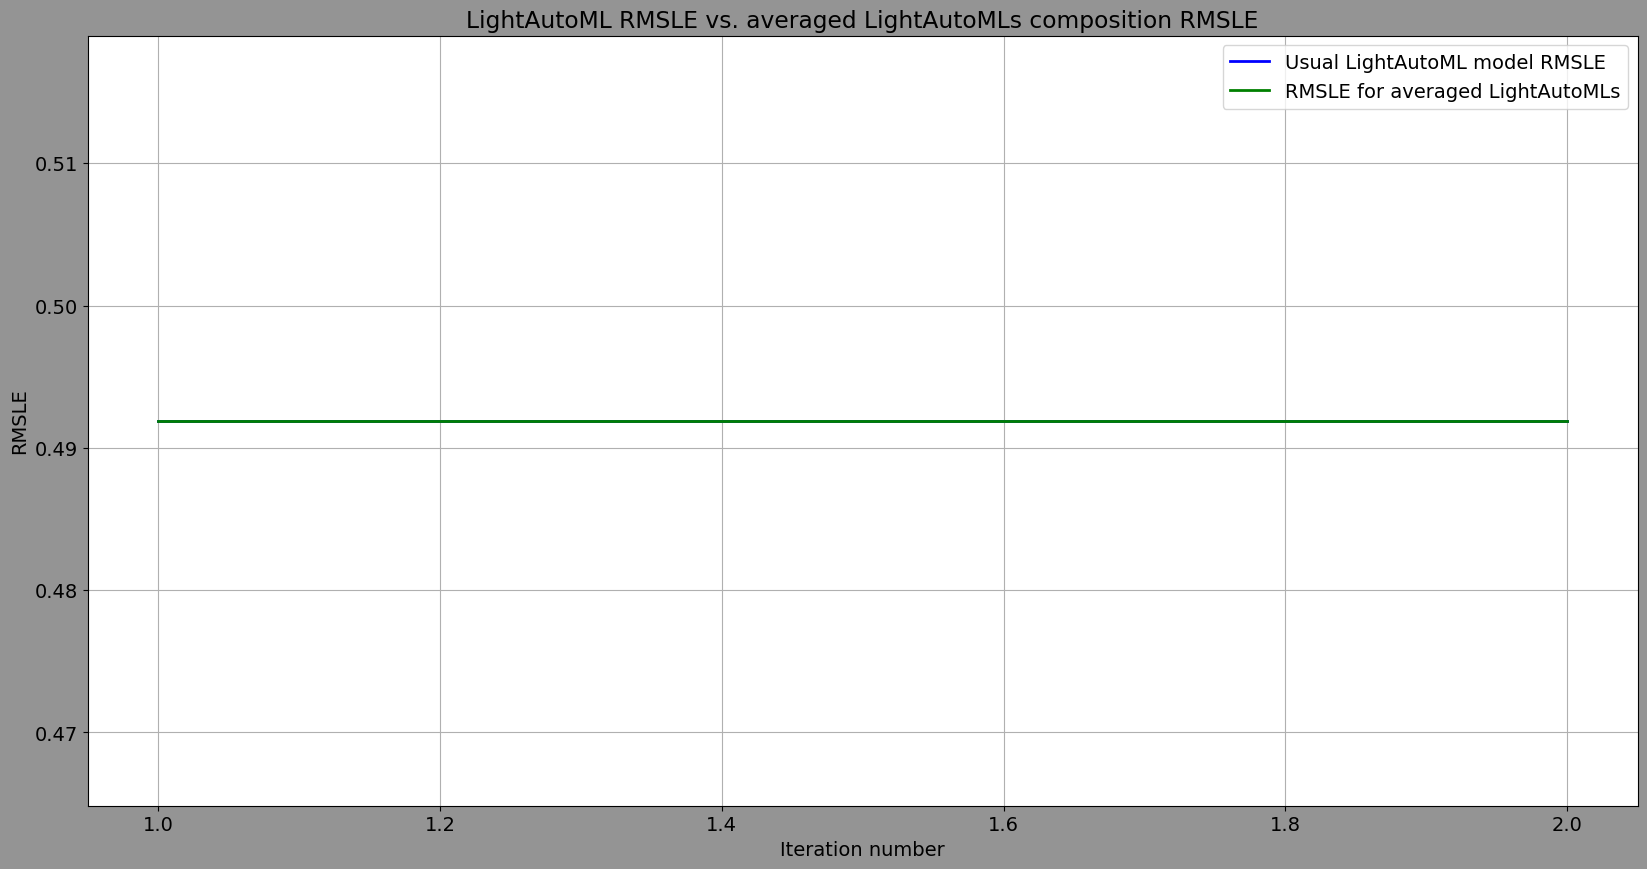

In [28]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), [res[0] for res in results], color = 'b', linewidth = 2, label = 'Usual LightAutoML model RMSLE')
plt.plot(range(1, cnt_trained + 1), [res[1] for res in results], color = 'g', linewidth = 2, label = 'RMSLE for averaged LightAutoMLs')
plt.grid()
plt.legend()
plt.title('LightAutoML RMSLE vs. averaged LightAutoMLs composition RMSLE')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE')
plt.show()

In [29]:
mean_rmsle = np.mean([res[0] for res in results])
mean_rmsle

0.49190925120204015

In [30]:
differences = np.array([res[1] - mean_rmsle for res in results])

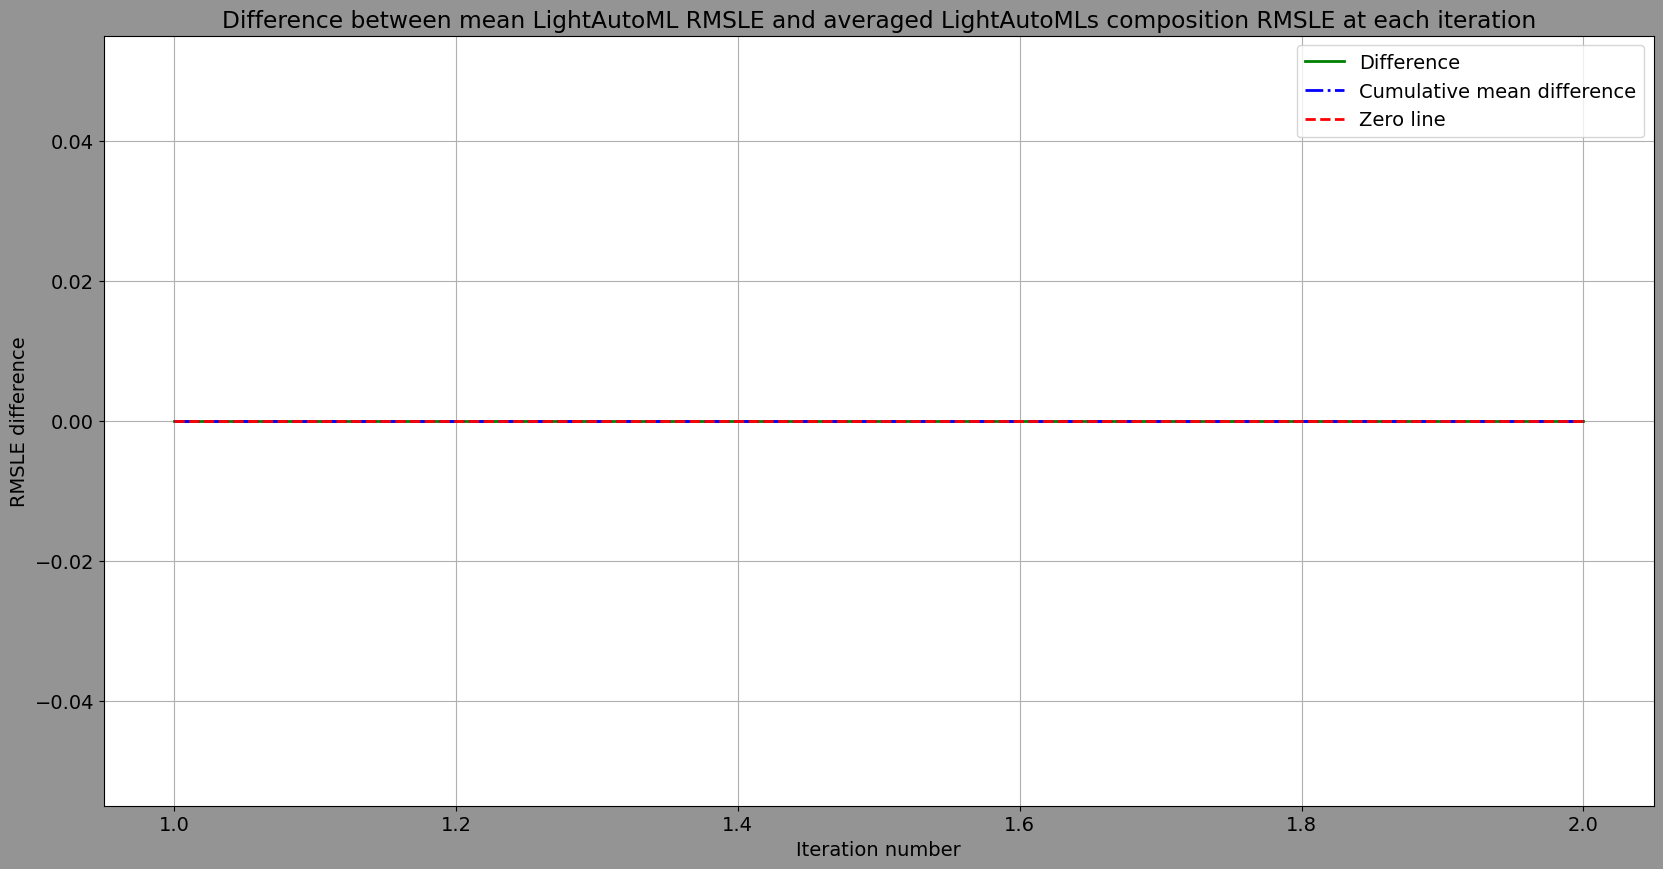

In [31]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), differences, color = 'g', linewidth = 2, label = 'Difference')
plt.plot(range(1, cnt_trained + 1), [np.mean(differences[0:i+1]) for i in range(len(differences))], 'b-.', linewidth = 2, label = 'Cumulative mean difference')
plt.plot(range(1, cnt_trained + 1), [0.0 for res in results], 'r--', linewidth = 2, label = 'Zero line')
plt.grid()
plt.legend()
plt.title('Difference between mean LightAutoML RMSLE and averaged LightAutoMLs composition RMSLE at each iteration')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE difference')
plt.show()

In [32]:
data_with_pseudolabels = val_data.copy()
data_with_pseudolabels['price'] = test_pred_full_0.copy() 

new_dataset = pd.concat([train_data, data_with_pseudolabels]).sample(frac = 1, random_state = 13).reset_index(drop = True)
print(train_data.shape, new_dataset.shape)

(150826, 42) (188533, 42)


In [33]:
train_data['price'].describe()

count    1.508260e+05
mean     4.388875e+04
std      7.889816e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64

In [34]:
new_dataset['price'].describe()

count    1.885330e+05
mean     4.243369e+04
std      7.143968e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.100000e+04
75%      4.970349e+04
max      2.954083e+06
Name: price, dtype: float64

In [36]:
cnt_trained = 0
results = []
rs_list = list(range(42, 44))
for it, rs in enumerate(rs_list):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    # Train AutoML
    automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs})
    oof_pred = automl.fit_predict(new_dataset, roles = roles, verbose = 0)
    
    # Predict on test
    test_pred = automl.predict(val_data)
    cnt_trained += 1
    
    # Save predictions
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]
    
    # Check scores for current predict and aggregated one
    rmsle_usual = mean_squared_log_error(val_data['price'].values, test_pred.data[:, 0]) ** 0.5
    rmsle_full = mean_squared_log_error(val_data['price'].values, test_pred_full / cnt_trained) ** 0.5
    results.append((rmsle_usual, rmsle_full, rmsle_full - rmsle_usual))
    
    print('Check scores...')
    print('Holdout score: {}'.format(rmsle_usual))
    print('Holdout score full: {}'.format(rmsle_full))
    print('Difference: {}'.format(rmsle_full - rmsle_usual))



START RANDOM_STATE = 42
Check scores...
Holdout score: 0.48685357995469736
Holdout score full: 0.48685357995469736
Difference: 0.0
START RANDOM_STATE = 43
Check scores...
Holdout score: 0.4870306555579446
Holdout score full: 0.4868090446321132
Difference: -0.00022161092583139474


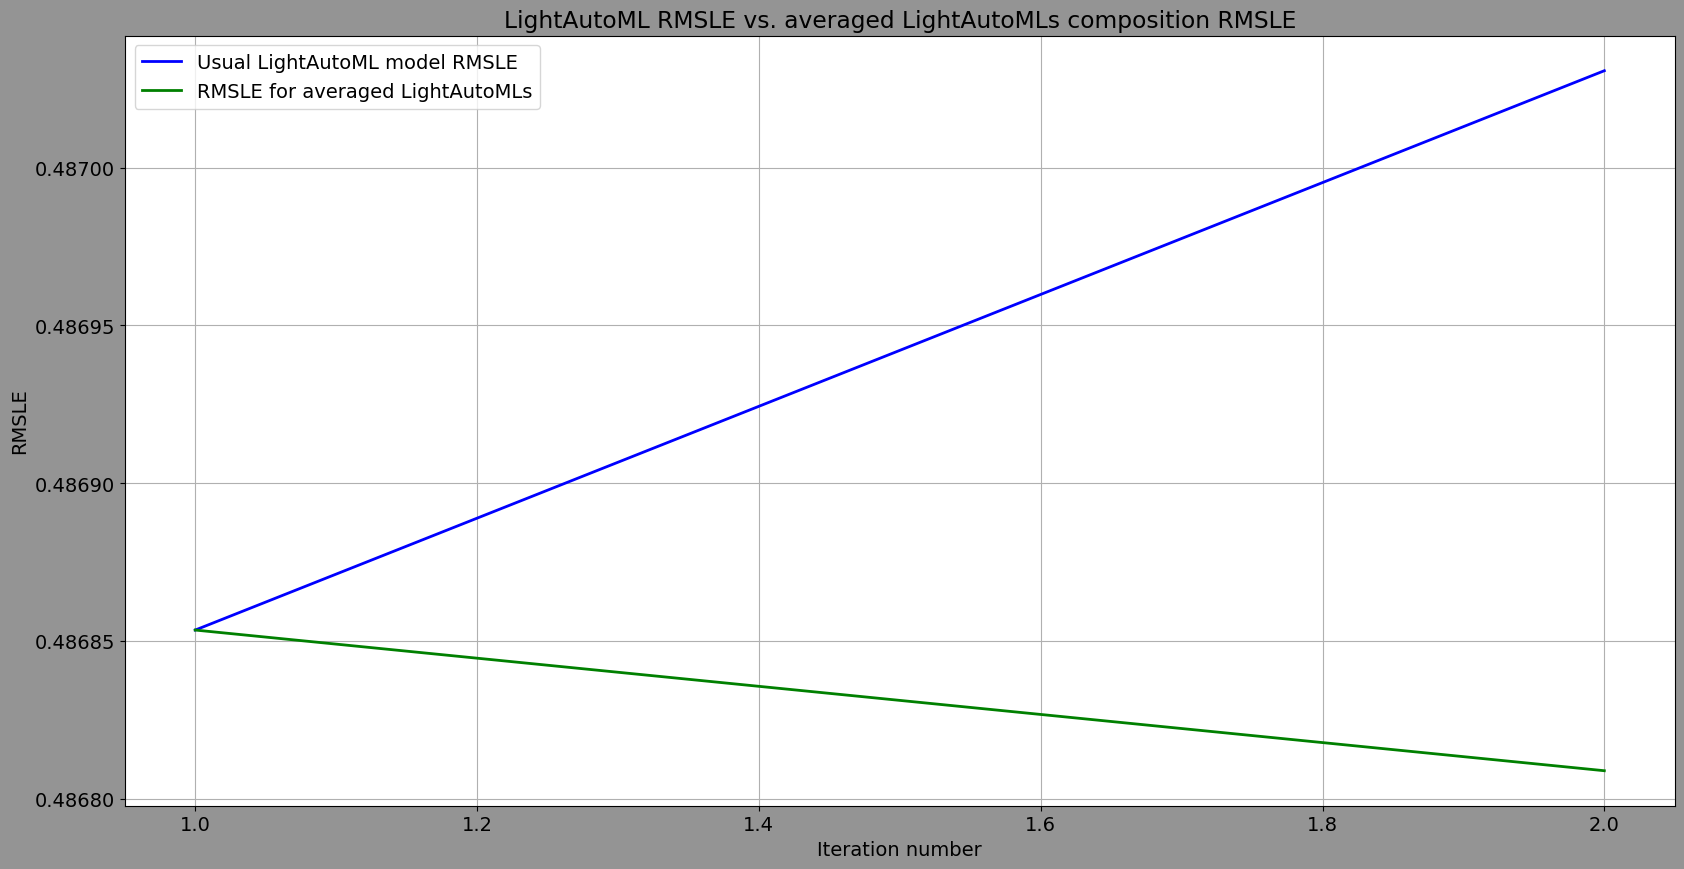

In [37]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), [res[0] for res in results], color = 'b', linewidth = 2, label = 'Usual LightAutoML model RMSLE')
plt.plot(range(1, cnt_trained + 1), [res[1] for res in results], color = 'g', linewidth = 2, label = 'RMSLE for averaged LightAutoMLs')
plt.grid()
plt.legend()
plt.title('LightAutoML RMSLE vs. averaged LightAutoMLs composition RMSLE')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE')
plt.show()

In [38]:
mean_rmsle = np.mean([res[0] for res in results])
mean_rmsle

0.486942117756321

In [39]:
differences = np.array([res[1] - mean_rmsle for res in results])

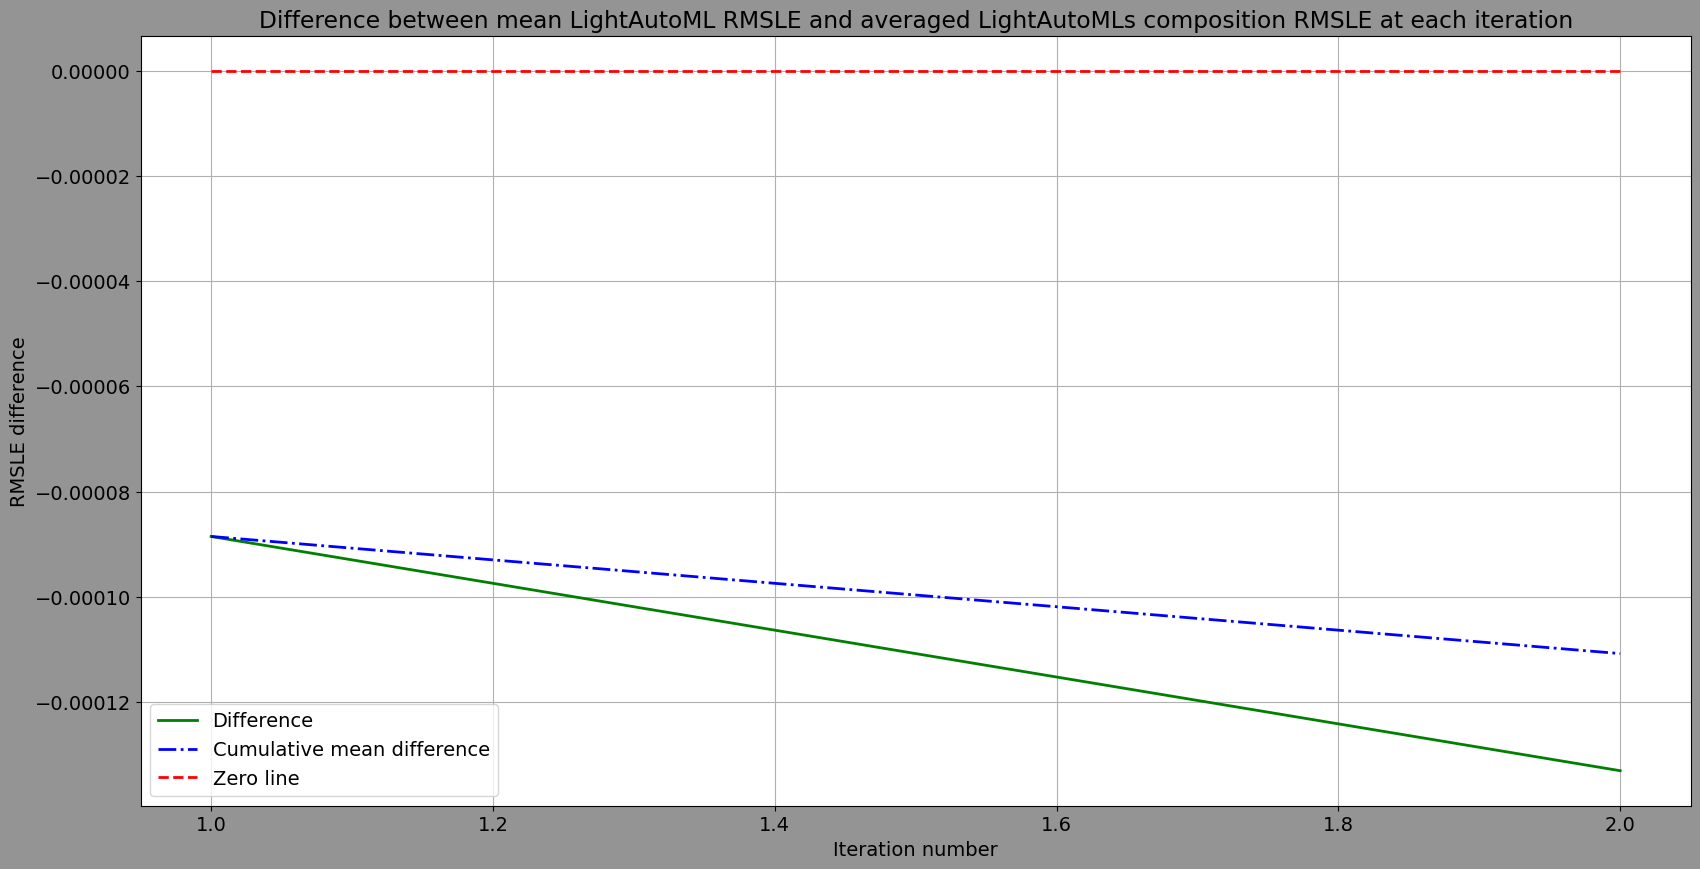

In [40]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), differences, color = 'g', linewidth = 2, label = 'Difference')
plt.plot(range(1, cnt_trained + 1), [np.mean(differences[0:i+1]) for i in range(len(differences))], 'b-.', linewidth = 2, label = 'Cumulative mean difference')
plt.plot(range(1, cnt_trained + 1), [0.0 for res in results], 'r--', linewidth = 2, label = 'Zero line')
plt.grid()
plt.legend()
plt.title('Difference between mean LightAutoML RMSLE and averaged LightAutoMLs composition RMSLE at each iteration')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE difference')
plt.show()

In [42]:
cnt_trained = 0
results = []
rs_list = list(range(42, 44))
for it, rs in enumerate(rs_list):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs})
    oof_pred = automl.fit_predict(train_df, roles = roles, verbose = 0)
    
    test_pred = automl.predict(test)
    cnt_trained += 1
    
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]
    
    rmsle_usual = mean_squared_log_error(train_df['price'].values, oof_pred.data[:, 0]) ** 0.5
    rmsle_full = mean_squared_log_error(train_df['price'].values, oof_pred_full / cnt_trained) ** 0.5
    results.append((rmsle_usual, rmsle_full, rmsle_full - rmsle_usual))
    
    print('Check scores...')
    print('OOF score: {}'.format(rmsle_usual))
    print('OOF score full: {}'.format(rmsle_full))
    print('Difference: {}'.format(rmsle_full - rmsle_usual))

START RANDOM_STATE = 42
Check scores...
OOF score: 0.4897980895352128
OOF score full: 0.4897980895352128
Difference: 0.0
START RANDOM_STATE = 43
Check scores...
OOF score: 0.4900505511570448
OOF score full: 0.4891455668145082
Difference: -0.0009049843425366078


In [43]:
test_pred_full_0 = test_pred_full.copy() / cnt_trained

In [44]:
test_data_with_pseudolabels = test.copy()
test_data_with_pseudolabels['price'] = test_pred_full_0

full_dataset = pd.concat([train_df, test_data_with_pseudolabels]).sample(frac = 1, random_state = 13).reset_index(drop = True)
print(train_df.shape, full_dataset.shape)

(188533, 42) (314223, 42)


In [45]:
cnt_trained = 0
results = []
rs_list = list(range(42, 44))
for it, rs in enumerate(rs_list):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': ['lgb', 'lgb_tuned', 'cb', 'cb_tuned']},
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs})
    oof_pred = automl.fit_predict(full_dataset, roles = roles, verbose = 0)
    
    test_pred = automl.predict(test)
    cnt_trained += 1
    
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]

START RANDOM_STATE = 42
START RANDOM_STATE = 43


In [46]:
sub['price'] = test_pred_full / cnt_trained
sub.to_csv('LightAutoML_pseudolabelled_multistart.csv', index = False)

In [39]:
Y_train = train_data[TARGET_NAME].copy().to_numpy()
Y_val = val_data[TARGET_NAME].copy().to_numpy()
type(Y_train)
train_preds = automl.predict(train_data).to_numpy()
val_preds = automl.predict(val_data).to_numpy()
train_preds

array([[64332.254],
       [44734.523],
       [42009.16 ],
       ...,
       [25669.2  ],
       [36003.04 ],
       [47744.145]], dtype=float32)

In [42]:
Y_train = train_data[TARGET_NAME].copy().to_numpy()
Y_val = val_data[TARGET_NAME].copy().to_numpy()

train_preds = automl.predict(train_data).data
val_preds = automl.predict(val_data).data

print(rmse(Y_train, train_preds))
print(rmse(Y_val, val_preds))

73141.140625
73142.703125


Task('reg', loss='mae', metric='mae') 73141.140625 73142.703125

In [43]:
test_preds = automl.predict(test)
sub['price'] = test_preds.data[:,0]
sub.to_csv('lightautoml_submision.csv', index=None)

In [ ]:
automl = TabularUtilizedAutoML(task = task,
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)
out_of_fold_predictions = automl.fit_predict(train_df, roles = roles, verbose = 1)
joblib.dump(automl, 'lightautoml_utilized.pkl.pkl')

[17:56:41] Start automl utilizator with listed constraints:
[17:56:41] - time: 3600.00 seconds
[17:56:41] - CPU: 16 cores
[17:56:41] - memory: 16 GB

[17:56:41] If one preset completes earlier, next preset configuration will be started

[17:56:41] ==================================================
[17:56:41] Start 0 automl preset configuration:
[17:56:41] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[17:56:41] Stdout logging level is INFO.
[17:56:41] Task: reg

[17:56:41] Start automl preset with listed constraints:
[17:56:41] - time: 3600.00 seconds
[17:56:41] - CPU: 16 cores
[17:56:41] - memory: 16 GB

[17:56:41] Train data shape: (150826, 42)

[17:56:45] Layer 1 train process start. Time left 3595.59 secs
[17:56:52] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[17:57:07] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -5391927808.0
[17:57:07] Lvl_0_Pipe_0_Mo

Optimization Progress: 100%|██████████| 101/101 [03:22<00:00,  2.00s/it, best_trial=82, best_value=-5.85e+9]

[18:00:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[18:00:54] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[18:01:16] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5265338368.0
[18:01:16] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[18:01:16] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[18:01:38] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5298457600.0
[18:01:38] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[18:01:38] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:44<00:00,  2.22s/it, best_trial=19, best_value=-5.9e+9]

[18:05:23] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[18:05:23] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[18:05:54] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5281624576.0
[18:05:54] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[18:05:54] Time left 3047.21 secs

[18:05:54] Layer 1 training completed.

[18:05:54] Blending: optimization starts with equal weights. Score = -5258263552.0000000
[18:05:54] Blending: iteration 0: score = -5246209536.0000000, weights = [0.         0.20791404 0.48771343 0.14757343 0.15679914]
[18:05:54] Blending: iteration 1: score = -5246177280.0000000, weights = [0.         0.23466448 0.46850163 0.14800753 0.1488264 ]
[18:05:54] Blending: iteration 2: score = -5246176256.0000000, weights = [0.         0.23131356 0.4705529  0.14865556 0.14947803]
[18:05:54] Blending: no improvements for score. Terminated.

[18:05:54] Blending: best score = -5246176256.0000000, best weights = [0.         0.23131356 0.4705529  0.14865556 0.14947803]
[18:05:54] Automl preset training completed in 553.23 seconds

[18:05:54] Model description:
Fi

Optimization Progress: 100%|██████████| 101/101 [03:38<00:00,  2.16s/it, best_trial=89, best_value=-4.58e+9]

[18:10:13] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[18:10:13] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[18:10:39] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5272606720.0
[18:10:39] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[18:10:39] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[18:10:58] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5289117696.0
[18:10:58] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[18:10:58] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:37<00:00,  2.15s/it, best_trial=85, best_value=-4.66e+9]

[18:14:35] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[18:14:35] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[18:14:50] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5297069568.0
[18:14:50] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[18:14:50] Time left 2510.88 secs

[18:14:50] Layer 1 training completed.

[18:14:50] Blending: optimization starts with equal weights. Score = -5265079296.0000000
[18:14:50] Blending: iteration 0: score = -5251752448.0000000, weights = [0.         0.19756769 0.5185117  0.2839206  0.        ]
[18:14:50] Blending: iteration 1: score = -5251337728.0000000, weights = [0.         0.19244336 0.45698833 0.35056835 0.        ]
[18:14:50] Blending: iteration 2: score = -5251291648.0000000, weights = [0.         0.16094704 0.4798659  0.3591871  0.        ]
[18:14:51] Blending: no improvements for score. Terminated.

[18:14:51] Blending: best score = -5251291648.0000000, best weights = [0.         0.16094704 0.4798659  0.3591871  0.        ]
[18:14:51] Automl preset training completed in 536.29 seconds

[18:14:51] Model description:
Fi

Optimization Progress: 100%|██████████| 101/101 [01:38<00:00,  1.02it/s, best_trial=99, best_value=-6.46e+9]

[18:16:45] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[18:16:45] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[18:16:53] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5291610112.0
[18:16:53] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[18:16:53] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[18:17:11] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5306531328.0
[18:17:11] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[18:17:11] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:01<00:00,  1.80s/it, best_trial=81, best_value=-6.46e+9]

[18:20:12] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[18:20:12] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[18:20:34] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5296329728.0
[18:20:34] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[18:20:34] Time left 2167.16 secs

[18:20:34] Layer 1 training completed.

[18:20:34] Blending: optimization starts with equal weights. Score = -5294048768.0000000
[18:20:34] Blending: iteration 0: score = -5285928448.0000000, weights = [0.         0.12563561 0.42491138 0.1672069  0.28224605]
[18:20:34] Blending: iteration 1: score = -5285875200.0000000, weights = [0.         0.10966348 0.45464495 0.13531049 0.300381  ]
[18:20:34] Blending: iteration 2: score = -5285869568.0000000, weights = [0.         0.10899966 0.45811617 0.12322105 0.30966315]
[18:20:34] Blending: iteration 3: score = -5285869056.0000000, weights = [0.         0.10995875 0.458986   0.12270045 0.30835482]
[18:20:34] Blending: iteration 4: score = -5285868544.0000000, weights = [0.         0.11030909 0.45910662 0.11733493 0.31324935]
[18:20:34] Blending: be

Optimization Progress: 100%|██████████| 101/101 [01:49<00:00,  1.08s/it, best_trial=70, best_value=-6.24e+9]

[18:22:56] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[18:22:56] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[18:23:05] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5297672192.0
[18:23:05] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[18:23:05] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[18:23:22] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5311896064.0
[18:23:22] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[18:23:22] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [04:34<00:00,  2.72s/it, best_trial=75, best_value=-6.24e+9]

[18:27:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[18:27:57] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[18:28:12] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5311980032.0
[18:28:12] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[18:28:12] Time left 1709.47 secs

[18:28:12] Layer 1 training completed.

[18:28:12] Blending: optimization starts with equal weights. Score = -5283870720.0000000
[18:28:12] Blending: iteration 0: score = -5278368256.0000000, weights = [0.         0.41141537 0.298261   0.19002168 0.10030197]
[18:28:12] Blending: iteration 1: score = -5277543424.0000000, weights = [0.07292402 0.41833484 0.28423706 0.17350447 0.05099958]
[18:28:12] Blending: iteration 2: score = -5277471232.0000000, weights = [0.09004923 0.41796136 0.27025354 0.22173584 0.        ]
[18:28:12] Blending: iteration 3: score = -5277467648.0000000, weights = [0.08578084 0.415284   0.2729594  0.22597583 0.        ]
[18:28:12] Blending: iteration 4: score = -5277466624.0000000, weights = [0.08432342 0.41601753 0.27352038 0.22613871 0.        ]
[18:28:12] Blending: be

Optimization Progress: 100%|██████████| 101/101 [01:48<00:00,  1.08s/it, best_trial=99, best_value=-5.85e+9]

[18:30:26] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[18:30:26] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[18:30:32] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5292662784.0
[18:30:32] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[18:30:32] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[18:30:49] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5330019328.0
[18:30:49] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[18:30:49] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:34<00:00,  2.12s/it, best_trial=44, best_value=-5.84e+9]

[18:34:23] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[18:34:23] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[18:34:38] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5316682240.0
[18:34:38] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[18:34:38] Time left 1322.98 secs

[18:34:38] Layer 1 training completed.

[18:34:38] Blending: optimization starts with equal weights. Score = -5298259456.0000000
[18:34:38] Blending: iteration 0: score = -5287409152.0000000, weights = [0.         0.2981241  0.51882076 0.         0.18305519]
[18:34:38] Blending: iteration 1: score = -5287010304.0000000, weights = [0.05585596 0.32817027 0.48331785 0.         0.13265589]
[18:34:38] Blending: iteration 2: score = -5287007744.0000000, weights = [0.05597124 0.33392134 0.4787149  0.         0.13139252]
[18:34:39] Blending: iteration 3: score = -5287007232.0000000, weights = [0.05664023 0.33654788 0.47081268 0.         0.13599919]
[18:34:39] Blending: no improvements for score. Terminated.

[18:34:39] Blending: best score = -5287007232.0000000, best weights = [0.05664023 0.33654788

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[18:35:20] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:35:46] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5294636032.0
[18:35:46] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   1%|          | 1/101 [00:25<42:28, 25.49s/it, best_trial=0, best_value=-5.29e+9]

[18:35:46] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:36:13] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5279030784.0
[18:36:13] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   2%|▏         | 2/101 [00:53<44:05, 26.72s/it, best_trial=1, best_value=-5.28e+9]

[18:36:13] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:36:26] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5303459840.0
[18:36:26] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   3%|▎         | 3/101 [01:05<33:01, 20.22s/it, best_trial=1, best_value=-5.28e+9]

[18:36:26] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:36:39] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5282623488.0
[18:36:39] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   4%|▍         | 4/101 [01:18<28:01, 17.34s/it, best_trial=1, best_value=-5.28e+9]

[18:36:39] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:36:59] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5293836288.0
[18:36:59] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   5%|▍         | 5/101 [01:38<29:16, 18.29s/it, best_trial=1, best_value=-5.28e+9]

[18:36:59] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:37:10] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5295472640.0
[18:37:10] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   6%|▌         | 6/101 [01:49<25:14, 15.94s/it, best_trial=1, best_value=-5.28e+9]

[18:37:10] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:37:21] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5273051648.0
[18:37:21] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   7%|▋         | 7/101 [02:01<22:31, 14.38s/it, best_trial=6, best_value=-5.27e+9]

[18:37:21] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:37:49] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5275735552.0
[18:37:49] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   8%|▊         | 8/101 [02:28<28:50, 18.61s/it, best_trial=6, best_value=-5.27e+9]

[18:37:49] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:38:02] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5285056512.0
[18:38:02] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:   9%|▉         | 9/101 [02:42<26:03, 17.00s/it, best_trial=6, best_value=-5.27e+9]

[18:38:02] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:38:27] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5292169216.0
[18:38:27] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:  10%|▉         | 10/101 [03:06<29:14, 19.28s/it, best_trial=6, best_value=-5.27e+9]

[18:38:27] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:38:37] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5274225152.0
[18:38:37] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:  11%|█         | 11/101 [03:17<24:54, 16.61s/it, best_trial=6, best_value=-5.27e+9]

[18:38:37] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:38:48] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5274230784.0
[18:38:48] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:  12%|█▏        | 12/101 [03:27<22:01, 14.85s/it, best_trial=6, best_value=-5.27e+9]

[18:38:48] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:39:05] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5289412096.0
[18:39:05] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:  13%|█▎        | 13/101 [03:44<22:30, 15.34s/it, best_trial=6, best_value=-5.27e+9]

[18:39:05] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:39:15] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5281253888.0
[18:39:15] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:  14%|█▍        | 14/101 [03:54<19:58, 13.77s/it, best_trial=6, best_value=-5.27e+9]

[18:39:15] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[18:39:31] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5295957504.0
[18:39:31] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


Optimization Progress:  15%|█▍        | 15/101 [04:10<23:55, 16.69s/it, best_trial=6, best_value=-5.27e+9]

[18:39:31] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[18:39:31] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[18:39:40] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5283047424.0
[18:39:40] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[18:39:40] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[18:40:01] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5313942016.0
[18:40:01] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[18:40:01] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[18:40:01] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:40:23] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5300237824.0
[18:40:23] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   1%|          | 1/101 [00:21<36:07, 21.68s/it, best_trial=0, best_value=-5.3e+9]

[18:40:23] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:40:43] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5309147648.0
[18:40:43] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   2%|▏         | 2/101 [00:42<34:32, 20.93s/it, best_trial=0, best_value=-5.3e+9]

[18:40:43] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:41:03] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5311321600.0
[18:41:03] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   3%|▎         | 3/101 [01:02<33:26, 20.47s/it, best_trial=0, best_value=-5.3e+9]

[18:41:03] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:41:23] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5319916544.0
[18:41:23] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   4%|▍         | 4/101 [01:22<33:04, 20.46s/it, best_trial=0, best_value=-5.3e+9]

[18:41:24] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:41:51] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5292106240.0
[18:41:51] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   5%|▍         | 5/101 [01:49<36:38, 22.90s/it, best_trial=4, best_value=-5.29e+9]

[18:41:51] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:42:11] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5311508992.0
[18:42:11] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   6%|▌         | 6/101 [02:09<34:46, 21.97s/it, best_trial=4, best_value=-5.29e+9]

[18:42:11] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:42:31] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5309147648.0
[18:42:31] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   7%|▋         | 7/101 [02:30<33:35, 21.44s/it, best_trial=4, best_value=-5.29e+9]

[18:42:31] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:42:52] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5311508992.0
[18:42:52] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   8%|▊         | 8/101 [02:50<32:42, 21.10s/it, best_trial=4, best_value=-5.29e+9]

[18:42:52] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:43:13] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5311111680.0
[18:43:13] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:   9%|▉         | 9/101 [03:11<32:21, 21.11s/it, best_trial=4, best_value=-5.29e+9]

[18:43:13] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:43:38] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5298215936.0
[18:43:38] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:  10%|▉         | 10/101 [03:36<33:57, 22.39s/it, best_trial=4, best_value=-5.29e+9]

[18:43:38] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:44:07] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5293896192.0
[18:44:07] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:  11%|█         | 11/101 [04:05<36:26, 24.29s/it, best_trial=4, best_value=-5.29e+9]

[18:44:07] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:44:35] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5293532672.0
[18:44:35] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:  12%|█▏        | 12/101 [04:34<37:57, 25.59s/it, best_trial=4, best_value=-5.29e+9]

[18:44:35] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[18:45:03] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5292102144.0
[18:45:03] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


Optimization Progress:  13%|█▎        | 13/101 [05:01<34:01, 23.20s/it, best_trial=12, best_value=-5.29e+9]

[18:45:03] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[18:45:03] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[18:45:20] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5313926656.0
[18:45:20] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[18:45:20] Time left 680.86 secs

[18:45:20] Layer 1 training completed.

[18:45:20] Blending: optimization starts with equal weights. Score = -5278885888.0000000
[18:45:20] Blending: iteration 0: score = -5271890944.0000000, weights = [0.         0.4679002  0.26320142 0.1244538  0.14444453]
[18:45:20] Blending: iteration 1: score = -5271049216.0000000, weights = [0.06654153 0.48023883 0.2364314  0.08239327 0.134395  ]
[18:45:20] Blending: iteration 2: score = -5271000064.0000000, weights = [0.0816907  0.4775493  0.23472545 0.06912251 0.13691205]
[18:45:21] Blending: iteration 3: score = -5270996480.0000000, weights = [0.08542327 0.47809443 0.23711422 0.06394099 0.13542713]
[18:45:21] Blending: iteration 4: score = -5270995968.0000000, weights = [0.0861645  0.47664604 0.2355536  0.06352016 0.13811573]
[18:45:21] Blending: bes

Optimization Progress:  91%|█████████ | 92/101 [01:49<00:10,  1.19s/it, best_trial=43, best_value=-5.86e+9]

[18:47:40] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[18:47:40] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[18:47:47] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5289117184.0
[18:47:47] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[18:47:47] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[18:48:04] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5324221440.0
[18:48:04] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[18:48:04] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:31<00:00,  2.10s/it, best_trial=93, best_value=-5.93e+9]

[18:51:36] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[18:51:36] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[18:52:00] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5300742144.0
[18:52:00] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[18:52:00] Time left 281.31 secs

[18:52:00] Layer 1 training completed.

[18:52:00] Blending: optimization starts with equal weights. Score = -5290809344.0000000
[18:52:00] Blending: iteration 0: score = -5283600384.0000000, weights = [0.         0.14601643 0.527863   0.         0.32612056]
[18:52:00] Blending: iteration 1: score = -5283092992.0000000, weights = [0.05634524 0.1430704  0.52822375 0.         0.27236065]
[18:52:00] Blending: iteration 2: score = -5283077120.0000000, weights = [0.06633713 0.14543848 0.5211402  0.         0.26708415]
[18:52:00] Blending: no improvements for score. Terminated.

[18:52:00] Blending: best score = -5283077120.0000000, best weights = [0.06633713 0.14543848 0.5211402  0.         0.26708415]
[18:52:00] Automl preset training completed in 399.41 seconds

[18:52:00] Model description:
Fin

['lightautoml_utilized.pkl.pkl']

In [34]:
val_preds = automl.predict(val_df)
print(f'Prediction for val_data:\n{val_preds}\nShape = {val_preds.shape}')
oof_rmse = rmse(train_df[TARGET_NAME].values, out_of_fold_predictions.data)
holdout_rmse = rmse(val_df[TARGET_NAME].values, val_preds.data)

print(f'OOF RMSE: {oof_rmse}')
print(f'HOLDOUT RMSE: {holdout_rmse}')

Prediction for val_data:
array([[37993.39 ],
       [52040.   ],
       [69087.25 ],
       ...,
       [17470.297],
       [72909.55 ],
       [45945.508]], dtype=float32)
Shape = (37707, 1)
OOF RMSE: 72368.6875
HOLDOUT RMSE: 72478.390625


30 cv : OOF RMSE: 71784.9375
HOLDOUT RMSE: 72496.875

50 cv : OOF RMSE: 71309.625
HOLDOUT RMSE: 72547.3984375

OOF RMSE: 72449.984375
HOLDOUT RMSE: 72464.5390625

In [35]:
test_preds = automl.predict(test)
print(test_preds)
sub['price'] = test_preds[0:].data
sub.to_csv('automl_submision.csv', index=None)

array([[17545.82 ],
       [78661.69 ],
       [52319.98 ],
       ...,
       [22250.86 ],
       [16866.059],
       [36238.67 ]], dtype=float32)
